# Applying the LLE Algorithm to the Swiss Roll Data Set - Part II

## Introduction

In the last tutorial, we used scikit-learn to generate a *locally linear embedding* of a sectioned version of the Swiss Roll data set. We then used Fovea's suite of non-linear dimensionality reduction tools to visualize each section's two-dimensional projection and to link those subplots to dynamic behavior in the 3D axes.

In this demo, we will build on the work of the last example. However, instead of sectioning the data before applying the LLE algorithm we will post-process the data and show how to use Fovea's layer functionality to visualize the "accrual" of the Swiss Roll and its projection in real time.

## Initializing the Data Set and Importing Required Packages

The initial setup of our script will proceed in an identical manner to the previous tutorial. First we take care of the required `import` statements (of which there are quite a few).

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import retina.core.axes
import retina.nldr as nldr 
import numpy as np
import math
from matplotlib import gridspec
from matplotlib.widgets import Slider
from sklearn import manifold, datasets

plt.ion()

Next, we use scikit-learn to generate the Swiss Roll data.

In [2]:
X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12,
                                             n_components=2)

And, of course, we create our Matplotlib figure and axes. This time we will set aside a single 3D axes for viewing the original data set and a single 2D axes for holding its projection. For good measure, let's also add a Matplotlib slider widget which we'll use to control the progression of our data's generation, later on down the line.

<IPython.core.display.Javascript object>


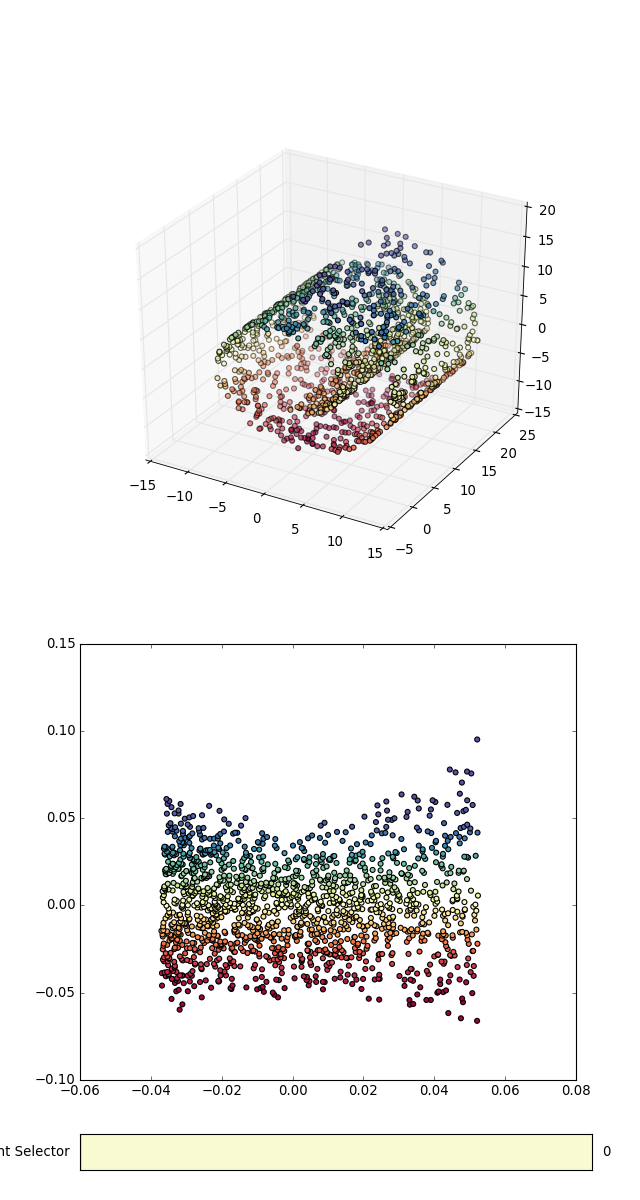

In [3]:
fig = plt.figure(figsize=(8, 15))
roll = fig.add_subplot(211, projection='Fovea3D')
proj = fig.add_subplot(212, projection='Fovea2D')
axcolor = 'lightgoldenrodyellow'
segselector = plt.axes([0.125, 0.025, .8, 0.03], axisbg=axcolor)

And there you have it - our bare bones figure construction.

## Using Fovea to Segment Our Data

Now that we have our figure ready to go, let's prepare our data. This time we'll use a new function from Fovea's NLDR module called `progressive_segment()`. The method signature looks like this:
```
progressive_segment(data, num_iterations, axis=0)
```
`data` is the data that you want to segment, `num_iterations` specifies the number of segments to be built up from the input data array, and `axis` is the column along which the data array is sorted. `progressive_segment` differs from the other NLDR utility functions in that instead of portioning the data array into equal parts, it returns progressively larger chunks of the array upon each internal iteration. Basically, an increment size is calculated by taking the number of rows of `data`, dividing that by `num_iterations`, and then slicing the array with a call like `data[0:i*increment, :]` where `i` is the current iteration number. Here we apply the progressive segmentation and sort our color array accordingly:

In [4]:
segs = nldr.mapping.progressive_segment(X_r, 10, axis=1)
roll_segs = nldr.mapping.progressive_segment(X, 10, axis=2)
color = color[color.argsort()]

## Building Up Our Plot Using Fovea's Layers

The action of the following code is simple. We define a color increment, `dcolor`, for indexing our color array, and then proceed to add a layer to both the 2D and 3D axes to hold each progressive segment. We then use the Fovea Axe's `build_layer` function to generate the plot for each layer.

In [5]:
dcolor = len(color)/len(segs)
for i in range(len(segs)):
    seg = segs[i]
    roll_seg = roll_segs[i]
    proj_layer = proj.add_layer('segment ' + str(int(i)))
    proj_layer.add_data(seg[:, 0], seg[:, 1])
    roll_layer = roll.add_layer('segment ' + str(int(i)))
    roll_layer.add_data(roll_seg[:,0], roll_seg[:,1], roll_seg[:,2])
    new_colors = color.copy()
    new_colors = new_colors[0:(i+1)*dcolor]
    proj.build_layer(proj_layer.name, plot=proj.scatter, c=new_colors, cmap=plt.cm.Spectral)
    roll.build_layer(roll_layer.name, plot=roll.scatter, c=new_colors, cmap=plt.cm.Spectral)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Finally, we showcase the most recently added layer so as not to have duplicated data present in either plot.

In [6]:
proj.showcase('segment 9')
roll.showcase('segment 9')

## Binding the Slider Widget to a Callback to Create Interactivity

Now that we've generated our static plot, it's time to add some interactive behavior! To do this, we create a Slider widget that we'll use for changing the data segment being visualized.

In [7]:
slid = Slider(segselector, 'Segment Selector', 0, 9, valinit=0, valfmt='%0.0f')

We also create an event callback which gets the currently selected integer value of the slider and calls on the Fovea Axe's `showcase` method in order to display the segment under consideration while hiding all others. We then use the Matplotlib `on_changed` method to connect this callback to the slider axes.

In [8]:
def update(val):
    seg_num = math.floor(slid.val)
    proj.showcase('segment ' + str(int(seg_num)))
    roll.showcase('segment ' + str(int(seg_num)))

slid.on_changed(update)

0

Now if you shimmy back up to our plot window, you'll see that you can drag the slider and watch both the 3D Swiss Roll and its projection be built up dynamically. This should assist you in determining which parts of the roll correspond with which parts of the 2D embedding and vice versa.